In [1]:
### -*- coding: utf-8 -*-
"""
Created on Mon May 24 13:26:13 2021

@author: kjsanche

Description: 
A function to load the 5 minute granules from MODIS channel 1 
(0.65 microns) and the contrail mask for ML with a CNN.

To do:
ASAP:
-cut up images
-separate testing data
-plot testing data vs mask



lower priority:
-optimize image shape by transforming back to original satellite swath projection
-save and set up to load data as tfrecord
-organize/markdown/comment code


Input:
Path   (string)

        
        
Output:
MODISCh1 (2D uint32)
MASK     (2D uint16)
"""


from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import struct
import os
import glob
import cv2
import gc
from itertools import compress
from UNET_Functions import unet_model, summary
from Sat_contrail_read import Extract_RawDef, extract_img, extract_mask, extract_imglist2, get_model_memory_usage
from scipy.spatial import ConvexHull
from scipy.ndimage import rotate
from format_input import *
import tensorflow as tf

sys_details = tf.sysconfig.get_build_info()
print(sys_details)
cudnn_version = sys_details["cudnn_version"]
cuda_version = sys_details["cuda_version"]

print('cuda version: ', cuda_version)
print('cudNN version: ',cudnn_version)
print('TF version: ', tf.version.VERSION)


NEWMASK = False # use updated masks?
NCHANNELS=3 #number of channels + 1 (3, 7 or 8)
DVERSION = 'v26' #
#augment_amount = 0
img_slice_size = 64
contrail_ratio = 3 #number of slices to keep without contrails:slices with contrails (2 = 2:1)
pixel_threshold = (img_slice_size**2)*0.005 #pixel threshold to determine if slice has a significant number of pixels labeled as contrail


#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.experimental.output_all_intermediates(True) 
path = os.getcwd()
proj_path = os.path.normpath(path + os.sep + os.pardir) #get parent directory
image_path = '/home/kjsanche/Desktop/ExternalSSD/SatContrailData/' #os.path.join(proj_path, 'data/')
save_TFrecord_path = '/home/kjsanche/Desktop/TFrecords/' 


image0065, image0380, image0680, image0850, image1100, image1200, image1330, AUX_list, mask_list, newmask_list = extract_imglist2(image_path)

N = len(image1200)
print(N)
print(len(mask_list))

OrderedDict([('cpu_compiler', '/home/builder/ktietz/aggregate/tensorflow_recipes/ci_cpu/tensorflow-base_1614583966145/_build_env/bin/x86_64-conda_cos6-linux-gnu-gcc'), ('cuda_compute_capabilities', ['compute_35', 'compute_52', 'compute_60', 'compute_61', 'compute_70', 'compute_75']), ('cuda_version', '10.1'), ('cudnn_version', '7'), ('is_cuda_build', True), ('is_rocm_build', False)])
cuda version:  10.1
cudNN version:  7
TF version:  2.4.1
105
105


## extract image dimensions

In [2]:
dim = Extract_RawDef(AUX_list)

## make dataset

In [3]:
img0065_filenames = tf.constant(image0065)
img0380_filenames = tf.constant(image0380)
img0680_filenames = tf.constant(image0680)
img0850_filenames = tf.constant(image0850)
img1100_filenames = tf.constant(image1100)
img1200_filenames = tf.constant(image1200)
img1330_filenames = tf.constant(image1330)

masks_filenames = tf.constant(mask_list)
newmasks_filenames = tf.constant(newmask_list)
#print(masks_filenames)
#print(newmasks_filenames)
dataset = tf.data.Dataset.from_tensor_slices((img0065_filenames, img0380_filenames, img0680_filenames, img0850_filenames, img1100_filenames, img1200_filenames, img1330_filenames, masks_filenames, newmasks_filenames, dim))
print(dataset)

<TensorSliceDataset shapes: ((), (), (), (), (), (), (), (), (), (2,)), types: (tf.string, tf.string, tf.string, tf.string, tf.string, tf.string, tf.string, tf.string, tf.string, tf.int64)>


In [4]:
def process_path(img0065_path, img0380_path, img0680_path, img0850_path, img1100_path, img1200_path, img1330_path, mask_path, newmask_path, dim):
# convert binary files to matrix of integers
    if NCHANNELS >=3:
        img5 = extract_img(str(img1100_path.numpy().decode('ascii')),int(dim[0].numpy()),int(dim[1].numpy()))
        img6 = extract_img(str(img1200_path.numpy().decode('ascii')),int(dim[0].numpy()),int(dim[1].numpy()))
        img = np.concatenate((img5, img6), axis=2)
    if NCHANNELS >=7:
        img2 = extract_img(str(img0380_path.numpy().decode('ascii')),int(dim[0].numpy()),int(dim[1].numpy()))
        img3 = extract_img(str(img0680_path.numpy().decode('ascii')),int(dim[0].numpy()),int(dim[1].numpy()))
        img4 = extract_img(str(img0850_path.numpy().decode('ascii')),int(dim[0].numpy()),int(dim[1].numpy()))
        img7 = extract_img(str(img1330_path.numpy().decode('ascii')),int(dim[0].numpy()),int(dim[1].numpy()))
        img = np.concatenate((img2, img3, img4, img7, img), axis=2)
    if NCHANNELS ==8:
        img1 = extract_img(str(img0065_path.numpy().decode('ascii')),int(dim[0].numpy()),int(dim[1].numpy()))
        img = np.concatenate((img1, img), axis=2)



    #img = np.concatenate((img1, img2, img3, img4, img7, img5, img6), axis=2)
    
    
    
    with open(str(newmask_path.numpy().decode('ascii')), 'rb') as f:
        mask = np.zeros((4096,4096,1), dtype = int)
        x = np.load(f)
        mask[0:x.shape[0], 0:x.shape[1], 0] += x

    mask2 = extract_mask(str(mask_path.numpy().decode('ascii')),int(dim[0].numpy()),int(dim[1].numpy()))
    mask = np.concatenate((mask2, mask), axis=2)
        
    return tf.convert_to_tensor(img,dtype=tf.float16), tf.convert_to_tensor(mask,dtype=tf.int8)

def _set_shapes(img, mask):
    img.set_shape([4096, 4096, NCHANNELS-1])
    mask.set_shape([4096, 4096, 2])

    return img, mask 

#print(dataset)
image_ds = dataset.map(lambda aa, bb, cc, dd, ee, ff, gg, hh, ii, jj: tf.py_function(process_path, [aa, bb, cc, dd, ee, ff, gg, hh, ii, jj], [tf.float16, tf.int8]))
image_ds = image_ds.map(_set_shapes)
print(image_ds)



<MapDataset shapes: ((4096, 4096, 2), (4096, 4096, 2)), types: (tf.float16, tf.int8)>


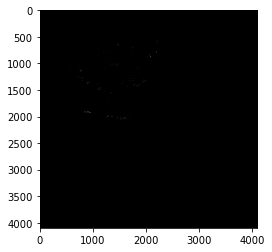

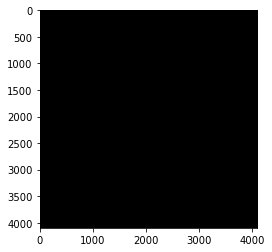

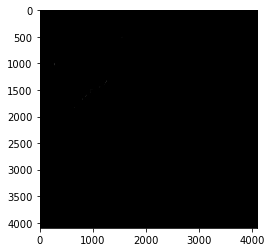

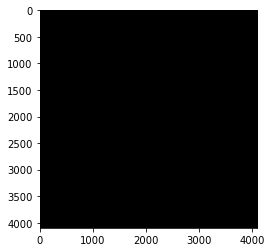

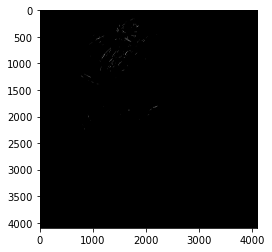

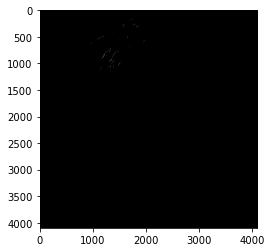

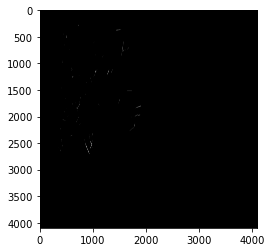

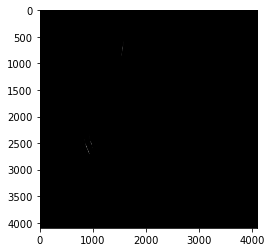

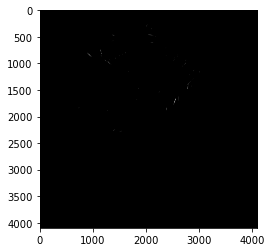

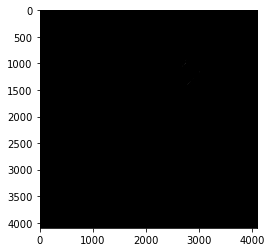

In [12]:
for image, mask in image_ds.take(5):
    sample_image, sample_mask = image, mask
    fig = plt.figure()
    satImgax = plt.imshow(mask[:,:,0], cmap = 'gray')
    plt.show()
    satImgax2 = plt.imshow(mask[:,:,1], cmap = 'gray')
    plt.show()

In [ ]:
def image_IOU(mask1, mask2):
    inter = 0
    union = 0
    #for _, mask in image_ds:
    #mask = mask.numpy()
    mask1[mask1>1]=1
    mask2[mask2>1]=1
    mask1[mask1<1]=0
    mask2[mask2<1]=0

    #create list of true indicies for both masks
    a = list(compress(range(len(mask1[:,:].flatten())), mask1[:,:].flatten()))
    b = list(compress(range(len(mask2[:,:].flatten())), mask2[:,:].flatten()))

    IOU = len(list(set(a).intersection(b)))/(len(list(set(a).union(b)))+1e-6)
    inter += len(list(set(a).intersection(b)))
    union += len(list(set(a).union(b)))
    #print(f"intersection = {len(list(set(a).intersection(b)))}")
    #print(f"union = {len(list(set(a).union(b)))}")
    print(f"IOU ={IOU}")
    return inter, union, IOU

7

In [28]:
#NOT WORKING ANYMORE.... not sure why

inter = 0
union = 0
for _, mask in image_ds:
    mask = mask.numpy()
    mask1=mask[:,:,0]
    mask2=mask[:,:,1]
    mask1[mask1>1]=1
    mask2[mask2>1]=1
    mask1[mask1<1]=0
    mask2[mask2<1]=0
    #mask[mask>1]=1
    
    #create list of true indicies for both masks
    a = list(compress(range(len(mask1[:,:].flatten())), mask1[:,:].flatten()))
    b = list(compress(range(len(mask2[:,:].flatten())), mask2[:,:].flatten()))
    print(len(a))
    print(len(b))
    print(len(newmask.flatten()))
    print(len(oldmask.flatten()))
    IOU = len(list(set(a).intersection(b)))/len(list(set(a).union(b)))
    inter += len(list(set(a).intersection(b)))
    union += len(list(set(a).union(b)))
    #print(f"intersection = {len(list(set(a).intersection(b)))}")
    #print(f"union = {len(list(set(a).union(b)))}")
    print(f"IOU ={IOU}")
    


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
meanIOU = inter/union
print(meanIOU)